# Sinodial function Parameters with EP
## David Omar Paredes Paredes y Abraham Maximiliano Ávalos Corrales

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_absolute_error

In [ ]:
class EPproblem:
  def generate_initial_population(self, p_size) -> list:...#
  def _compare(self, fitness_a, fitness_b) -> int:...

  def mutate(self, g, alpha:float, eps:float):#
    g_len = len(g)
    n_x   = int(g_len / 2)
    newg  = np.copy(g)
    newg_x = newg[:n_x]
    newg_s = newg[n_x:]

    for i in range(n_x):
      newg_s[i] = max(
          abs(newg_s[i]*(1.0 + np.random.normal(0, alpha))),
          eps
      )
      newg_x[i] = newg_x[i] + np.random.normal(0, newg_s[i])

    return newg
  def check_individual_integrity(self, g) -> bool: return True

  def get_prob_dist(self, E:list):...
  def generate_from_prob_dist(self, Pd:list, n_p:int) -> list:...

  def get_fitness(self, G:list, F:list=None):...#
  def get_elite(self, G:list, F:list) -> (list, list):...#
  def update_elite(self, E, newE, Fe, newFe):...#

  def solved(self, Fe:list): return False#
  def has_progress_metric(self) -> bool: return False
  def get_progress_metric(self, F:list) -> float:...
  def get_progress_max(self) -> float:...
  def get_variation(self, F:list) -> float:...
  def custom_print(self, G:list, F:list):...

class SinoidalEP(EPproblem):
    def __init__(self, filename, f_alpha:float=0.001):
      self.f_alpha = f_alpha
      self.specie_size = 6
      self.filename = filename
      self.df = pd.read_csv(filename)

    def generate_initial_population(self, p_size):
      pop = np.zeros((p_size, self.specie_size))

      for i in range(p_size):
        pop[i, :3] = np.random.uniform(-1000, 1001, 3)
        pop[i, 3:] = np.random.uniform(0.1, 100, 3)

      return pop

    def get_fitness(self, G):
      fitness = np.zeros((len(G)))

      for i, indiv in enumerate(G):
        error = 0
        for idx, row in enumerate(self.df.to_numpy()):#self.df.iterrow():
          ypred = indiv[0] * np.sin(indiv[1]*row[0]+indiv[2])
          ycorrect = row[1]
          error += abs(ypred-ycorrect)
        fitness[i] = error + indiv[1]*self.f_alpha

      return fitness

    def get_elite(self, G, F):
      lowest_error = np.argmin(F)#F.index(min(F))
      return np.copy(G[lowest_error]), F[lowest_error]

    def update_elite(self, elite, newElite, Fe, newFe):
      if(newFe<Fe):
        return newElite, newFe
      return elite, Fe

    def custom_print(self, G: list, F: list, E, Fe):
      ypred = np.zeros((len(self.df['x'])))
      data = self.df.to_numpy()

      indiv = E
      for idx, row in enumerate(self.df.to_numpy()):#self.df.iterrow()::
        ypred[idx] = indiv[0] * np.sin(indiv[1]*row[0]+indiv[2])

      plt.scatter(data[:, 0], data[:, 1], c='blue')
      plt.scatter(data[:, 0], ypred, c='orange')
      plt.grid(True)
      plt.show()






In [ ]:
class solverEP:
  def __init__(
      self,
      problem: EPproblem,
      alpha:float= 0.2,
      eps:float  = 0.1,
      p_size:int = 50,
      max_it:int = 1000
      # Formatting options for progress bar
      ,FEEDBACK_INT:int = 10
      ,MAX_F_LEN:int    = 30
      ,MAX_K_LEN:int    = 20
      ,MAX_G_LEN:int    = 10
      ,SPINNER:list[str]= ['\\', '|', '/', '-']
      ,verbose:bool     = False
      ,use_custom_print:bool= False
  ):
      self.problem = problem
      self.alpha   = alpha
      self.eps     = eps
      self.p_size  = p_size
      self.max_it  = max_it

      # Formatting options for progress bar
      self.FEEDBACK_INT = FEEDBACK_INT
      self.MAX_F_LEN    = MAX_F_LEN
      self.MAX_K_LEN    = MAX_K_LEN
      self.MAX_G_LEN    = MAX_G_LEN
      self.SPINNER      = SPINNER
      self.SPINNER_LEN  = len(self.SPINNER)
      self.verbose      = verbose
      self.use_custom_print= use_custom_print

      # solve() variables
      self.G = None
      self.F = None
      self.elite = None
      self.Fe = None
      self.n_it = 0
      self.converged = False

  def _print_progress(self, n_k:int):
    if self.verbose:
      print(f'\nIteration: {n_k}/{self.max_it}')
      if self.use_custom_print:
        self.problem.custom_print(self.G, self.F, self.elite, self.Fe)
      else:
        print(f'///Population///')
        print(self.G[: min(len(self.G), self.MAX_G_LEN) ], end='\n\n')
        print(self.F[: min(len(self.F), self.MAX_G_LEN) ])
        print(f'///Elite///')
        print(self.elite, end='\n\n')
        print(self.Fe)
    else:
      spinner_idx:int = int(n_k/self.FEEDBACK_INT)%self.SPINNER_LEN
      k_percentage    = n_k/float(self.max_it)*100
      filled_k        = int(self.MAX_K_LEN *n_k // self.max_it)
      k_bar           = '#'*filled_k + '-'*(self.MAX_K_LEN - filled_k)

      print(f'\r{self.SPINNER[spinner_idx]}', end='')
      print(f' Iteration:[{k_bar}]{k_percentage:.2f}%', end=' ')

      if self.problem.has_progress_metric():
        progress = self.problem.get_progress_metric(self.Fe)
        filled_p = int(self.MAX_F_LEN * progress // self.problem.get_progress_max())
        p_bar = '#'*filled_p + '-'*(self.MAX_F_LEN - filled_p)
        variation = self.problem.get_variation(self.F)

        print(f'Fitness:[{p_bar}]pm {variation:.2f}', end='')
      #----------
  # end _print_progress

  def solve(self):
    self.G = self.problem.generate_initial_population(self.p_size)
    self.F = self.problem.get_fitness(self.G)
    self.elite, self.Fe = self.problem.get_elite(self.G, self.F)

    self._print_progress(0)

    for k in range(1, self.max_it+1):
      self.n_it = k
      if self.problem.solved(self.Fe):
        self._print_progress(k)
        self.converged = True
        break

      newG = np.zeros_like(self.G)
      for i, species in enumerate(self.G):
        newG[i] = self.problem.mutate(species, self.alpha, self.eps)

      newF = self.problem.get_fitness(newG)
      Ge_for_concat = np.atleast_2d(self.elite)
      Fe_for_concat = np.atleast_1d(self.Fe)
      Gconcat = np.concatenate([self.G, newG, Ge_for_concat])
      Fconcat = np.concatenate([self.F, newF, Fe_for_concat])
      best    = np.argsort(Fconcat)

      self.G = np.copy(Gconcat[best[:self.p_size]])
      self.F = self.problem.get_fitness(self.G)
      newElite, newFe = self.problem.get_elite(self.G, self.F)

      self.elite, self.Fe = self.problem.update_elite(self.elite, newElite, self.Fe, newFe)
      if k%self.FEEDBACK_INT == 1 or k==self.max_it:
        self._print_progress(k)
    # end for



In [ ]:
problem= SinoidalEP(
    "/content/drive/Shareddrives/TrabajoOpti2/datos.csv",
    f_alpha=0.0
)


Iteration: 0/200


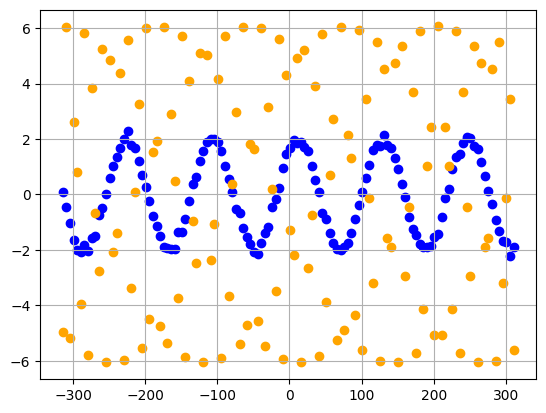


Iteration: 1/200


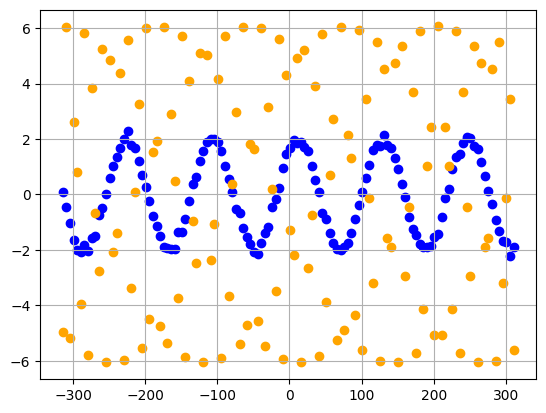


Iteration: 91/200


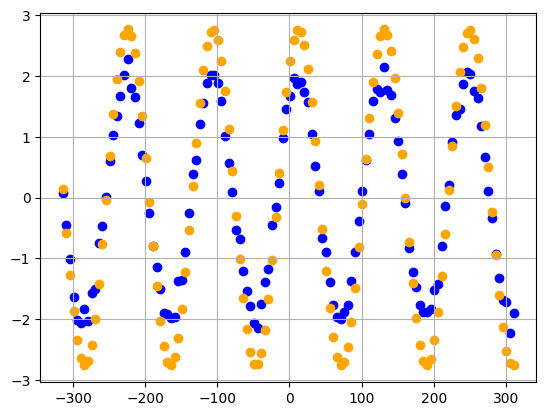


Iteration: 181/200


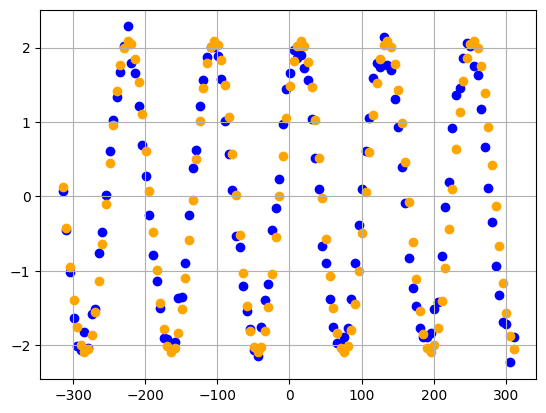


Iteration: 200/200


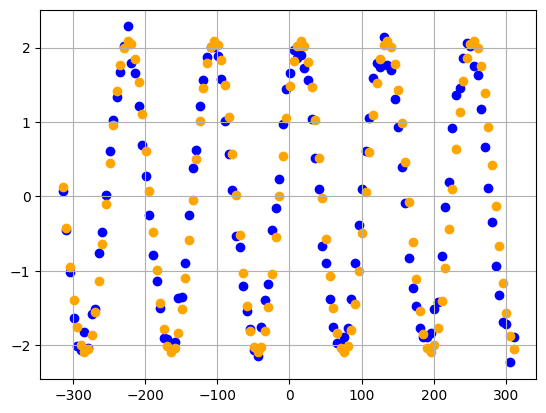

In [ ]:
#df = pd.read_csv("/content/drive/Shareddrives/TrabajoOpti2/datos.csv")
solver = solverEP(
    problem,
    alpha = 0.2, eps= 0.1,
    p_size=100, max_it=200, FEEDBACK_INT=90,
    verbose=True, use_custom_print=True
)
solver.solve()

In [ ]:
print(solver.elite)
print(solver.Fe)
# print('————————————-')
# print(solver.F)
# print('————————————-')
# print(solver.G)

[-2.09345919e+00 -9.18549134e+02  5.56276009e+02  5.31362636e-01
  4.75635433e+00  2.55700230e+01]
39.021118042546846


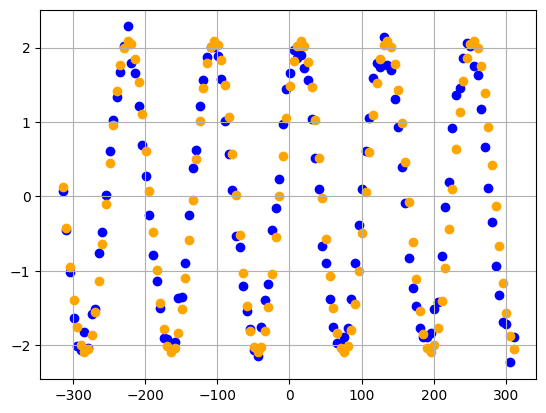

In [ ]:
problem.custom_print(None, None, solver.elite, solver.Fe)